In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/kaggle-sf-dst-through-1/kaggle_task.csv
/kaggle/input/kaggle-sf-dst-through-1/sample_submission.csv/sample_submission.csv
/kaggle/input/kaggle-sf-dst-through-1/main_task.csv/main_task.csv


In [2]:
import collections
from collections import Counter

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
df_train = pd.read_csv('/kaggle/input/kaggle-sf-dst-through-1/main_task.csv/main_task.csv')
df_test = pd.read_csv('/kaggle/input/kaggle-sf-dst-through-1/kaggle_task.csv')
sample_submission = pd.read_csv('/kaggle/input/kaggle-sf-dst-through-1/sample_submission.csv/sample_submission.csv')

In [6]:
#ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

In [7]:
data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [8]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
5935,id_5935,Paris,['French'],3929.0,$$ - $$$,519.0,"[['Cool place', 'Great evening'], ['01/06/2018...",/Restaurant_Review-g187147-d4990732-Reviews-Le...,d4990732,0,0.0
35178,id_1952,Prague,['Cafe'],1955.0,$,3.0,"[['Treasure in our neighbourhood'], ['09/14/20...",/Restaurant_Review-g274707-d7626286-Reviews-Ca...,d7626286,1,5.0
32305,id_7084,Barcelona,"['American', 'Steakhouse', 'Barbecue']",7085.0,$$ - $$$,105.0,"[['Average', 'Terrible food and service. Pleas...",/Restaurant_Review-g187497-d3998679-Reviews-Ri...,d3998679,1,3.0
49690,id_390,Hamburg,"['Vietnamese', 'Vegetarian Friendly']",391.0,$$ - $$$,13.0,"[['Not only mainstream dishes', 'Easy weekday ...",/Restaurant_Review-g187331-d12125766-Reviews-L...,d12125766,1,5.0
42675,id_3773,Barcelona,NaN,3774.0,NaN,5.0,"[[], []]",/Restaurant_Review-g187497-d5614259-Reviews-Me...,d5614259,1,5.0


In [9]:
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

Перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак.
Добавляем столбец с информацией о пропусках и заполняем пропуски в столце 'Number of Reviews' нулями (можено попробовать заполнением средним или средним по городу и тд...)

In [10]:
data['Number of Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Number of Reviews'].fillna(0, inplace=True)

In [11]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number of Reviews_isNAN        2
dtype: int64

Для кодирования категориальных признаков есть множество подходов:
Label Encoding,
One-Hot Encoding,
Target Encoding,
Hashing.

Добавляем дамми-столбцы с городами подходом One-Hot Encoding

In [12]:
City=data['City']

In [13]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [14]:
data['City']=City

In [15]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,City
45718,id_1505,"['German', 'European', 'Central European']",1507.0,$$ - $$$,55.0,"[['good food but please invest in service', 'A...",/Restaurant_Review-g187323-d2269134-Reviews-Th...,d2269134,1,4.0,...,0,0,0,0,0,0,0,0,0,Berlin
4327,id_4327,"['Italian', 'Mediterranean', 'European', 'Vege...",446.0,$$ - $$$,525.0,"[['Nice location - average food ....', 'They c...",/Restaurant_Review-g188057-d1025141-Reviews-Re...,d1025141,0,0.0,...,0,0,0,0,0,0,0,0,0,Geneva
13725,id_398,NaN,399.0,NaN,4.0,"[['For students', 'Best option around for stud...",/Restaurant_Review-g274873-d10347901-Reviews-N...,d10347901,1,4.0,...,0,0,0,0,0,0,0,0,0,Ljubljana
35497,id_6924,NaN,6928.0,NaN,4.0,"[[], []]",/Restaurant_Review-g187514-d5493100-Reviews-Dr...,d5493100,1,3.5,...,0,0,0,0,0,0,0,0,0,Madrid
22681,id_11160,['French'],11162.0,$$ - $$$,45.0,"[['Just ok', 'Good food'], ['12/17/2017', '06/...",/Restaurant_Review-g187147-d3736250-Reviews-L_...,d3736250,1,3.5,...,0,1,0,0,0,0,0,0,0,Paris


Добавляем столбец с категориальным признаком: столица ли это? (1 или 0)

In [16]:
data['City'].unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

In [17]:
capitals=['Paris', 'Stockholm', 'London', 'Berlin', 'Bratislava', 'Vienna', 'Rome', 'Madrid', 'Dublin',
          'Brussels', 'Warsaw', 'Budapest', 'Copenhagen', 'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
          'Helsinki', 'Edinburgh', 'Ljubljana', 'Athens', 'Luxembourg']

In [18]:
def if_it_capital(x):
    if x in capitals:
        return 1
    else:     
        return 0

In [19]:
data['Is_it_cpital']=data['City'].apply(if_it_capital)

Добавляем столбец с признаком принадлежности к более демократичному стилю.

In [20]:
PP=['Oporto', 'Bratislava', 'Barcelona', 'Madrid', 'Warsaw', 'Budapest', 
    'Lisbon', 'Prague', 'Helsinki', 'Ljubljana', 'Athens', 'Krakow', 'Amsterdam']
NPP=['Paris', 'Stockholm', 'London', 'Munich', 'Milan', 'Vienna', 
     'Rome', 'Dublin', 'Brussels', 'Zurich', 'Copenhagen', 'Lyon', 
     'Hamburg', 'Oslo', 'Edinburgh', 'Geneva', 'Luxembourg', 'Berlin']
XXPP=['Paris', 'Stockholm', 'London', 'Milan', 'Zurich',  
     'Oslo', 'Geneva', 'Luxembourg']

In [21]:
def pp(x):
    if x in PP:
        return 1
    else:
        return 0

In [22]:
data['PP']=data['City'].apply(pp)

In [23]:
def xxpp(x):
    if x in PP:
        return 1
    else:
        return 0

In [24]:
data['XXPP']=data['City'].apply(xxpp)

Добавляем столбец с порядковым номером города в рейтинге по количеству городов

In [25]:
c=Counter()

for city in data['City']:
    c[city]+=1

In [26]:
Cities = list(c.items())
Cities.sort(key=lambda i: i[1])

In [27]:
Cities_dict={}
i=1
for city in Cities:
    Cities_dict.setdefault(city[0], i)
    i+=1

In [28]:
def inner_rating(x):
    return Cities_dict[x]

In [29]:
data['inner_rating']=data['City'].apply(inner_rating)

Добавялем стобцы с категориями уровня цен.

In [30]:
data['Price Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

In [31]:
data['Price Range'].fillna('$$ - $$$', inplace=True)

In [32]:
Price_Range=data['Price Range']
data = pd.get_dummies(data, columns=[ 'Price Range',])
data['Price Range']=Price_Range

Добавляем столбец с уровнем цен в численной интерпретации.

In [33]:
def price_to_number(x):
    if x=='$$ - $$$':
        return 2
    elif x=='$':
        return 1
    else:
        return 3    

In [34]:
data['Price']=data['Price Range'].apply(price_to_number)

Добавялем столбец с датой последнего отзыва.

In [35]:
data['Reviews']=data['Reviews'].fillna('[[], []]')
data['Dates_Reviews']=data['Reviews'].apply(lambda x:x.split("], [")[1][:-2])    
data['Dates_Reviews']=data['Dates_Reviews'].apply(lambda x:x.split(", "))  
data['Last_Review']=data['Dates_Reviews'].apply(lambda x:list(x)[0][1:-1]) 

In [36]:
def drop_space(x):
    if len(x)>=10:
        return x
    elif len(x)==0:     
        return None    

In [37]:
data['Last_Review']=data['Last_Review'].apply(drop_space)

In [38]:
data['Last_Review'] = pd.to_datetime(data['Last_Review']) 

In [39]:
LR=data['Last_Review'].mean().timestamp()

In [40]:
def change_time_to_unix(x):
    if len(str(x))>3:
        return x.timestamp()
    else:     
        return LR   

In [41]:
data['Last']=data['Last_Review'].apply(change_time_to_unix)

Добавляем столбец с датой предыдущего отзыва.

In [42]:
data['Previous_Review']=data['Dates_Reviews'].apply(lambda x:str(x)[18:-2]) 
data['Previous_Review'].apply(drop_space)
data['Previous_Review'] = pd.to_datetime(data['Previous_Review']) 

In [43]:
PR=data['Previous_Review'].mean().timestamp()

In [44]:
def change_time_to_unix_2(x):
    if len(str(x))>3:
        return x.timestamp()
    else:     
        return PR   

In [45]:
data['Previous']=data['Previous_Review'].apply(change_time_to_unix_2)

Добавляем столбцы тепло/средне/холодно.

In [46]:
cold=['Stockholm', 'Berlin', 'Munich', 'Bratislava', 'Vienna', 'Dublin', 'Warsaw', 'Copenhagen', 'Amsterdam', 
      'Hamburg', 'Prague', 'Oslo', 'Helsinki', 'Edinburgh', 'Luxembourg', 'Krakow', 'Zurich']
norm=['Paris', 'London',   'Milan', 'Madrid', 'Brussels', 'Budapest','Lyon', 'Geneva', 'Ljubljana']
warm=['Oporto', 'Rome', 'Barcelona', 'Lisbon', 'Athens']

In [47]:
cold_series=[]
norm_series=[]
warm_series=[]

for city in data['City']:
    if city in cold:
        cold_series.append(1)
    else:
        cold_series.append(0)
    if city in norm:
        norm_series.append(1)
    else:
        norm_series.append(0)
    if city in warm:
        warm_series.append(1)
    else:
        warm_series.append(0) 

In [48]:
data['Cold']=pd.Series(cold_series)
data['Norm']=pd.Series(norm_series)
data['Warm']=pd.Series(warm_series)

Добавляем столбец с информацией о пропусках в списке кухонь.

In [49]:
data['Cuisine Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

Добавялем столбец  со счетчиком количества представленных кухонь.

In [50]:
data['Cuisine_qtt']=data['Cuisine Style']
data['Cuisine_qtt']=data['Cuisine_qtt'].dropna().apply(lambda x:len(x.split(', ')))
data['Cuisine_qtt']=data['Cuisine_qtt'].fillna(data['Cuisine_qtt'].mean())

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 63 columns):
Restaurant_id              50000 non-null object
Cuisine Style              38410 non-null object
Ranking                    50000 non-null float64
Number of Reviews          50000 non-null float64
Reviews                    50000 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number of Reviews_isNAN    50000 non-null uint8
City_Amsterdam             50000 non-null uint8
City_Athens                50000 non-null uint8
City_Barcelona             50000 non-null uint8
City_Berlin                50000 non-null uint8
City_Bratislava            50000 non-null uint8
City_Brussels              50000 non-null uint8
City_Budapest              50000 non-null uint8
City_Copenhagen            50000 non-null uint8
City_Dublin     

In [52]:
# убираем не нужные для модели признаки
data.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
# убираем остальные сомнительные признаки 
data.drop(['Cuisine Style', 'Reviews', 'URL_TA', 'Price Range', 
           'Dates_Reviews', 'Last_Review', 'Previous_Review', 'City'], axis = 1, inplace=True)

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 53 columns):
Ranking                    50000 non-null float64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number of Reviews_isNAN    50000 non-null uint8
City_Amsterdam             50000 non-null uint8
City_Athens                50000 non-null uint8
City_Barcelona             50000 non-null uint8
City_Berlin                50000 non-null uint8
City_Bratislava            50000 non-null uint8
City_Brussels              50000 non-null uint8
City_Budapest              50000 non-null uint8
City_Copenhagen            50000 non-null uint8
City_Dublin                50000 non-null uint8
City_Edinburgh             50000 non-null uint8
City_Geneva                50000 non-null uint8
City_Hamburg               50000 non-null uint8
City_Helsinki              50000 non-null uint8
City_Krakow          

In [54]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [55]:
# проверяем
train_data.shape, X.shape, X_train.shape, X_test.shape

((40000, 52), (40000, 51), (32000, 51), (8000, 51))

In [56]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [57]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [58]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.203699375


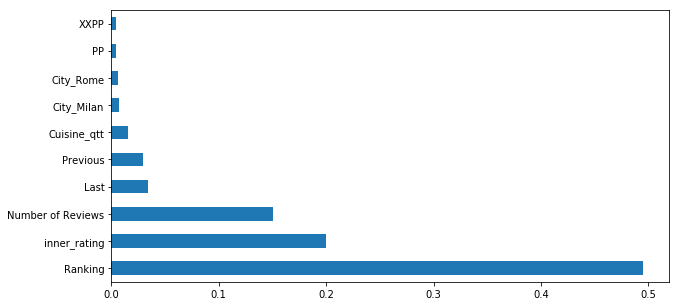

In [59]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [60]:
test_data = data.query('sample == 0').drop(['sample'], axis=1)
test_data = test_data.drop(['Rating'], axis=1)

In [61]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [62]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

,Restaurant_id,Rating
0,id_0,3.115
1,id_1,4.095
2,id_2,4.485
3,id_3,4.245
4,id_4,4.465
